<a href="https://colab.research.google.com/github/Bombbom/ML4SecurityProject/blob/main/Simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple RNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
# vector_filename ="/home/bombbom/Desktop/ReChecker/reentrancy_1671_fragment_vectors.pkl"
vector_filename = "/content/drive/MyDrive/Submit/NT522_Project/dataset_10000_record_fixednew_fragment_vectors.pkl"
data = pd.read_pickle(vector_filename)

In [3]:
from __future__ import print_function

import warnings
import numpy as np
# from keras.utils import to_categorical
# from sklearn.metrics import confusion_matrix
# from sklearn.utils import compute_class_weight
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM, ReLU, Activation
# from keras.layers.recurrent import SimpleRNN
# from keras.layers import SimpleRNN
# from keras.optimizers import Adamax
# from sklearn.model_selection import train_test_split
# from parser import parameter_parser


from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, ReLU, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adamax
# from sklearn.utils import compute_class_weight
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

In [4]:
vectors = np.stack(data.iloc[:, 0].values)
# vectors = vectors.reshape()
labels = data.iloc[:, 1].values

In [5]:
positive_idxs = np.where(labels == 1)[0]
negative_idxs = np.where(labels == 0)[0]
idxs = np.concatenate([positive_idxs, negative_idxs])
undersampled_negative_idxs = np.random.choice(negative_idxs, len(positive_idxs), replace=False)
resampled_idxs = np.concatenate([positive_idxs, undersampled_negative_idxs])
x_train, x_test, y_train, y_test = train_test_split(vectors[resampled_idxs], labels[resampled_idxs],train_size=0.8,random_state=1, stratify=labels[resampled_idxs])

In [6]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [7]:
y_train[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
dropout = 0.2
# y_train = to_categorical(y_train)
lr = 0.002
batch_size = 64
epochs = 10
threshold = 0.5
# def create_model():
#     model = Sequential()
#     model.add(SimpleRNN(300, input_shape=(vectors.shape[1], vectors.shape[2])))
#     model.add(ReLU())
#     model.add(Dropout(dropout))
#     model.add(Dense(300))
#     model.add(ReLU())
#     model.add(Dropout(dropout))
#     model.add(Dense(2, activation='softmax'))
#     return model
class_weights =  class_weight.compute_class_weight(class_weight='balanced', classes=[0, 1], y=labels)
adamax = Adamax(lr)
model = Sequential()
model.add(SimpleRNN(300, input_shape=(vectors.shape[1], vectors.shape[2])))
model.add(ReLU())
model.add(Dropout(dropout))
model.add(Dense(300))
model.add(ReLU())
model.add(Dropout(dropout))
model.add(Dense(2, activation='softmax'))


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 300)               180300    
                                                                 
 re_lu (ReLU)                (None, 300)               0         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 300)               90300     
                                                                 
 re_lu_1 (ReLU)              (None, 300)               0         
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 6

In [10]:
model.compile(loss='binary_crossentropy', optimizer=adamax, metrics=['accuracy'])
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
125/125 [==============================] - 32s 240ms/step - loss: 0.5311 - accuracy: 0.7048
Epoch 2/10
125/125 [==============================] - 32s 245ms/step - loss: 0.4683 - accuracy: 0.7439
Epoch 3/10
125/125 [==============================] - 28s 227ms/step - loss: 0.4389 - accuracy: 0.7682
Epoch 4/10
125/125 [==============================] - 28s 228ms/step - loss: 0.4229 - accuracy: 0.7779
Epoch 5/10
125/125 [==============================] - 28s 228ms/step - loss: 0.4055 - accuracy: 0.7881
Epoch 6/10
125/125 [==============================] - 29s 229ms/step - loss: 0.3956 - accuracy: 0.7940
Epoch 7/10
125/125 [==============================] - 31s 245ms/step - loss: 0.3814 - accuracy: 0.7999
Epoch 8/10
125/125 [==============================] - 28s 226ms/step - loss: 0.3718 - accuracy: 0.8039
Epoch 9/10
125/125 [==============================] - 28s 226ms/step - loss: 0.3638 - accuracy: 0.8105
Epoch 10/10
125/125 [==============================] - 28s 228ms/step - l

In [11]:
# evaluate the keras model
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

63/63 [==============================] - 6s 99ms/step - loss: 0.4111 - accuracy: 0.7920
Accuracy: 79.20


In [12]:
predictions = (model.predict(x_test, batch_size=batch_size)).round()
predictions = (predictions >= threshold)

32/32 [==============================] - 3s 89ms/step


In [13]:
tn, fp, fn, tp = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)).ravel()

In [14]:
print("Accuracy: ", (tp + tn) / (tp + tn + fp + fn))
print('False positive rate(FPR): ', fp / (fp + tn))
print('False negative rate(FNR): ', fn / (fn + tp))
recall = tp / (tp + fn)
print('Recall(TPR): ', recall)
precision = tp / (tp + fp)
print('Precision: ', precision)
print('F1 score: ', (2 * precision * recall) / (precision + recall))

Accuracy:  0.792
False positive rate(FPR):  0.107
False negative rate(FNR):  0.309
Recall(TPR):  0.691
Precision:  0.8659147869674185
F1 score:  0.7686318131256952


In [25]:
from sklearn.metrics import roc_curve, auc
fpr_list = []
tpr_list = []
threshold_list = []
roc_auc_list = []
y_pred = model.predict(x_test)
for i in range(2): # you can make this more general
    fpr, tpr, threshold = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    threshold_list.append(threshold)
    roc_auc_list.append(roc_auc)

63/63 [==============================] - 4s 63ms/step


In [26]:
fpr_list

[array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002,
        0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003,
        0.003, 0.003, 0.004, 0.004, 0.004, 0.005, 0.005, 0.006, 0.006,
        0.006, 0.006, 0.007, 0.007, 0.008, 0.008, 0.008, 0.008, 0.008,
        0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.009, 0.011, 0.014,
        0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014,
        0.014, 0.015, 0.015, 0.015, 0.015, 0.015, 0.016, 0.016, 0.016,
        0.016, 0.016, 0.016, 0.017, 0.017, 0.018, 0.018, 0.018, 0.018,
        0.018, 0.019, 0.019, 0.02 , 0.02 , 0.021, 0.021, 0.021, 0.021,
        0.025, 0.026, 0.026, 0.028, 0.028, 0.028, 0.028, 0.029, 0.029,
        0.03 , 0.03 , 0.031, 0.031, 0.031, 0.032, 0.032, 0.033, 0.033,
        0.033, 0.033, 0.034, 0.034, 0.035, 0.035, 0.036, 0.036, 0.037,
      

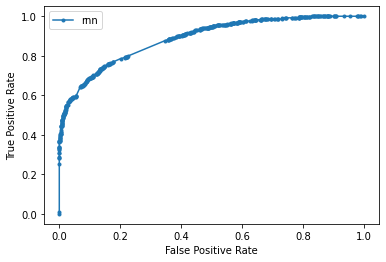

In [28]:
from matplotlib import pyplot
pyplot.plot(fpr_list[1], tpr_list[1], marker='.', label='rnn')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()